# Music Genre Prediction: Molten Cores

<img src="https://www.warcrafttavern.com/wp-content/uploads/2020/10/WoW-Classic-Molten-Core-Guide-1024x729.jpg" alt="img" width="95%"/>



# ____________________________________________________________________________________________________



## Notes:

- ### Instrumentalness: vocals in a track

- ### Speechiness: detects the pressents of vocal words in a track

- ### Music genre: (10 different types)
	0. Electronic
    1. Classical
    2. Jazz
    3. anime
    4. Rock
    5. country
    6. Rap
    7. Blues
    8. Hip-Hop
    9. Alternative

# Problems with table:

- [x] negative duration
- [x] missing tempos
- [x] rows 10000-10005 are nan values for every column
- [ ] negative loudness



##### [Markdown Guide cheat Sheet](https://www.markdownguide.org/cheat-sheet/)



# ____________________________________________________________________________________________________



## All Libaries & Imports 



In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
import copy
import sklearn
import xgboost as xgb

from sklearn import tree
from sklearn import preprocessing
from sklearn import utils
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from xgboost import XGBClassifier
from IPython.display import Image
from subprocess import call

# ____________________________________________________________________________________________________



# Functions



In [2]:
#This function returns the accuracy of tests
def getScore(y_test,y_hat):
    labels = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop']
    print((np.sum((y_test - y_hat)**2))/len(y_test) )#mean squared error
    print(classification_report(y_test, y_hat,target_names=[i+":" for i in labels]))

#This function replaces labels, such as Jazz, Rock, Rap, etc. with numbers. Each label now carries it's own number

def stringToInt(dataFrame,col):
    test = {}
    for i in dict(enumerate(dataFrame[col].unique())).items():#is a dictionary of the keys and corespodening number
        #makes it so the keys and values of the dictionary switch
        test[i[1]]=i[0]
    print(test,'\n')
    return dataFrame[col].map(test)

# ____________________________________________________________________________________________________



# Fixing problems with the Dataset



In [3]:
#getting dataframe
df = pd.read_csv("music_genre.csv")

#dropping columns
badInfo = ["instance_id","obtained_date","artist_name","track_name"]
df.drop(columns=badInfo,axis=1,inplace=True)

#dropping null rows
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True) #Very good practice to reset how your rows are counted when you drop rows.

#fixing the problem with 'tempo' column
df["tempo"]=df["tempo"].replace("?",np.nan)
df["tempo"] = df["tempo"].astype("float")
df["tempo"]=df.groupby("music_genre")["tempo"].transform(lambda x: x.fillna(x.mean(skipna=True)))
df['tempo'] = np.around(df['tempo'],2)

#fixing the problem with 'duration' column
df["duration_ms"]=df["duration_ms"].replace(-1.0,np.nan)
df["duration_ms"]=df.groupby("music_genre")["duration_ms"].transform(lambda x: x.fillna(x.mean(skipna=True)))
df['duration_ms'] = np.around(df['duration_ms'],2)

#changing the values from string to int
df['key'] = stringToInt(df,'key')
df['mode'] = stringToInt(df,'mode')
df['music_genre_name'] = df['music_genre']
df['music_genre'] = stringToInt(df,'music_genre')

pio.templates.default = "plotly_dark"

dfxg = copy.deepcopy(df)

{'A#': 0, 'D': 1, 'G#': 2, 'C#': 3, 'F#': 4, 'B': 5, 'G': 6, 'F': 7, 'A': 8, 'C': 9, 'E': 10, 'D#': 11} 

{'Minor': 0, 'Major': 1} 

{'Electronic': 0, 'Anime': 1, 'Jazz': 2, 'Alternative': 3, 'Country': 4, 'Rap': 5, 'Blues': 6, 'Rock': 7, 'Classical': 8, 'Hip-Hop': 9} 



# ____________________________________________________________________________________________________



## Spiting and scaling data



In [4]:
#Setting X to be all the input columns 
X = df.loc[:,df.columns[:-2]]


#Setting y to be the desired column
y= df['music_genre']#what we want

#Splitting test and train ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Scaling X variables
sc = preprocessing.StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

#for heat map
labels = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop']

# ____________________________________________________________________________________________________



## Plot



In [5]:
px.bar(df.sort_values(by=["music_genre_name"]), x='popularity', y='acousticness', color='music_genre_name')

# non danceable songs are of the highest acoustecness
# danceability and popularity are not correlated
# for each popularity, the least danceable songs tend to have the highest acousticness (at least until about 45 popularity)***

In [6]:
df = df.sort_values(by=["key"])
px.bar(df, x='music_genre_name', y='tempo',color='key')

# tempo is highest for classical
# tempo is lowest for electronic
# clear pattern in tempo per genre

<AxesSubplot:>

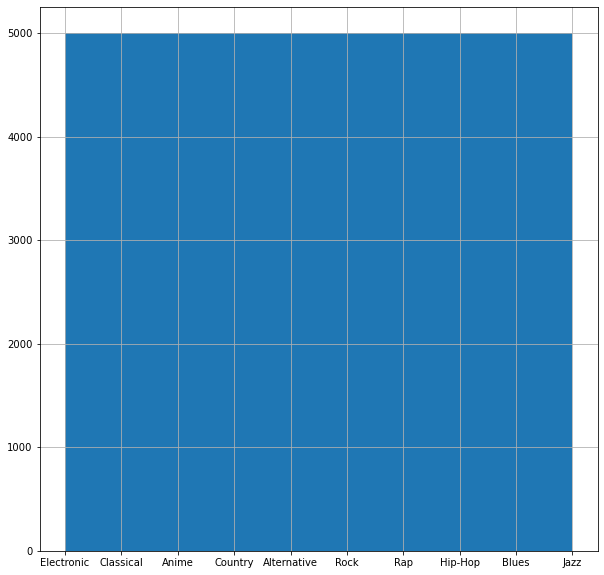

In [7]:
#shows that we have an equal amount of each genre
df["music_genre_name"].hist(figsize = (10, 10))

In [8]:
px.scatter_3d(df, x = "acousticness", y = "tempo", z = "popularity", color = "music_genre_name", size="duration_ms",size_max=50)

In [9]:
px.scatter(df.sort_values(by=["tempo"]), x = "loudness", y = "tempo", color = "music_genre_name", size="duration_ms",size_max=50,trendline="lowess")

# ____________________________________________________________________________________________________



# Logistic Regression 

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable.

In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.).

#### Types of LR

When we talk about Logistic Regression in general, we usually mean Binary logistic regression, although there are other types of Logistic Regression as well.

Logistic Regression can be divided into types based on the type of classification it does. With that in view, there are 3 types of Logistic Regression. Let’s talk about each of them:

- Binary Logistic Regression
- Multinomial Logistic Regression
- Ordinal Logistic Regression

In our case, we used **Multinomial Logistic Regression**

Multinomial Logistic Regression deals with cases when the target or independent variable has three or more possible values.

**For example**, the use of Chest X-ray images as features that give indication about one of the three possible outcomes (No disease, Viral Pneumonia, COVID-19). The multinomial Logistic Regression will use the features to classify the example into one of the three possible outcomes in this case. There can of course be more than three possible values of the target variable. in our case, there are **10**.



In [10]:

#Building a model
model = LogisticRegression()


#Fitting our data
model.fit(X_train, y_train)


#Prediction of X_test
y_pred = model.predict(X_test)


#Finding out accurasy of train variables
X_train_acc = model.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(X_train_acc*100))


#Finding out accuracy of test variables 
test_acc = model.score(X_test, y_test)
print("The Accuracy for Test Set is {}".format(test_acc*100))


#Printing classification report
getScore(y_test,y_pred)


The Accuracy for Training Set is 53.1575
The Accuracy for Test Set is 53.059999999999995
7.4106
              precision    recall  f1-score   support

 Electronic:       0.59      0.60      0.59       981
      Anime:       0.63      0.63      0.63      1008
       Jazz:       0.48      0.41      0.44       996
Alternative:       0.38      0.30      0.33       996
    Country:       0.47      0.60      0.53      1021
        Rap:       0.45      0.42      0.43       977
      Blues:       0.51      0.46      0.48      1012
       Rock:       0.51      0.65      0.57       984
  Classical:       0.78      0.79      0.79       972
    Hip-Hop:       0.48      0.46      0.47      1053

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



<AxesSubplot:>

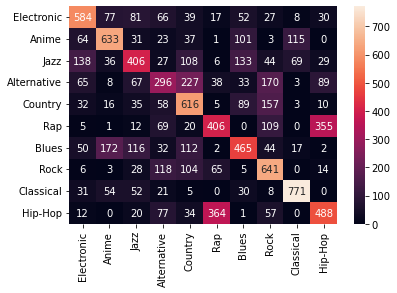

In [11]:
#Confusion matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

# ____________________________________________________________________________________________________



## Naive Bayes 

About  Naive Bayes :
Native Bayes is a machine learning model for classification that uses the Bayes Theorem(	<img src="https://s0.wp.com/latex.php?latex=%5Ctextrm%7BP%28H+%5Ctextbar+E%29+%3D+%7D+%C2%A0%5Cfrac%7B%5Ctextrm%7B+P%28E+%5Ctextbar+H%29+%2A+P%28H%29%7D%7D+%7B%5Ctextrm%7BP%28E%29%7D%7D&bg=ffffff&fg=000&s=0&c=20201002" alt="img" width="200"/>	)

  -  P(H) is the probability of hypothesis H being true. This is known as the prior probability.
  -  P(E) is the probability of the evidence(regardless of the hypothesis).
  -  P(E|H) is the probability of the evidence given that hypothesis is true.
  -  P(H|E) is the probability of the hypothesis given that the evidence is there.

Good at  predicting:

- Classical


Okay at predicting:

- Electronic
- Anime
- Hip-Hop

Bad at predicting:

- everything else



<AxesSubplot:>

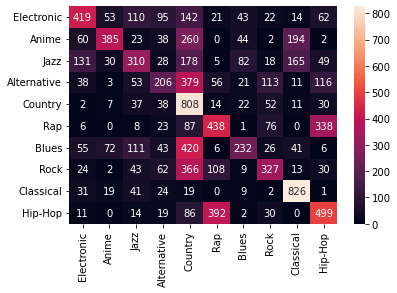

In [12]:
#Building a model
gnb = GaussianNB()

#Fitting data 
y_hat = gnb.fit(X_train, y_train).predict(X_test)

#Confusion Matrix 
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

In [13]:
# Accuracy of the test
getScore(y_test,y_hat)

8.4072
              precision    recall  f1-score   support

 Electronic:       0.54      0.43      0.48       981
      Anime:       0.67      0.38      0.49      1008
       Jazz:       0.41      0.31      0.36       996
Alternative:       0.36      0.21      0.26       996
    Country:       0.29      0.79      0.43      1021
        Rap:       0.42      0.45      0.43       977
      Blues:       0.50      0.23      0.31      1012
       Rock:       0.49      0.33      0.40       984
  Classical:       0.65      0.85      0.74       972
    Hip-Hop:       0.44      0.47      0.46      1053

    accuracy                           0.45     10000
   macro avg       0.48      0.45      0.43     10000
weighted avg       0.48      0.45      0.43     10000



# ____________________________________________________________________________________________________



## Classification Trees



**About Classification Trees:** 

Decision Trees \(DTs\) are a non\-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

**Pros**

- Simple to understand and to interpret. Trees can be visualized.
- Requires little data preparation.
- Able to handle both numerical and categorical data.
- Possible to validate a model using statistical tests.

**Cons**

- Decision\-tree learners can create over\-complex trees that do not generalize the data well.
- Decision trees can be unstable because small var iations in the data might result in a completely different tree being generated
- Predictions of decision trees are neither smooth nor continuous, but piecewise constant approximations as seen in the above figure.
- Decision tree learners create biased trees if some classes dominate.



Accuracy: 0.3196


[Text(0.5, 0.8333333333333334, 'X[0] <= 0.214\ngini = 0.9\nsamples = 40000\nvalue = [4019, 3992, 4004, 4004, 3979, 4023, 3988, 4016, 4028\n3947]'),
 Text(0.25, 0.5, 'X[8] <= -1.256\ngini = 0.852\nsamples = 22128\nvalue = [3379, 3912, 3145, 1590, 2460, 39, 3603, 49, 3801\n150]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.405\nsamples = 3834\nvalue = [47, 389, 348, 6, 22, 0, 110, 1, 2909, 2]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.842\nsamples = 18294\nvalue = [3332, 3523, 2797, 1584, 2438, 39, 3493, 48, 892, 148]'),
 Text(0.75, 0.5, 'X[10] <= -0.148\ngini = 0.826\nsamples = 17872\nvalue = [640, 80, 859, 2414, 1519, 3984, 385, 3967, 227, 3797]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.814\nsamples = 10207\nvalue = [433, 52, 687, 1638, 1392, 1147, 327, 3437, 219, 875]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.701\nsamples = 7665\nvalue = [207, 28, 172, 776, 127, 2837, 58, 530, 8, 2922]')]

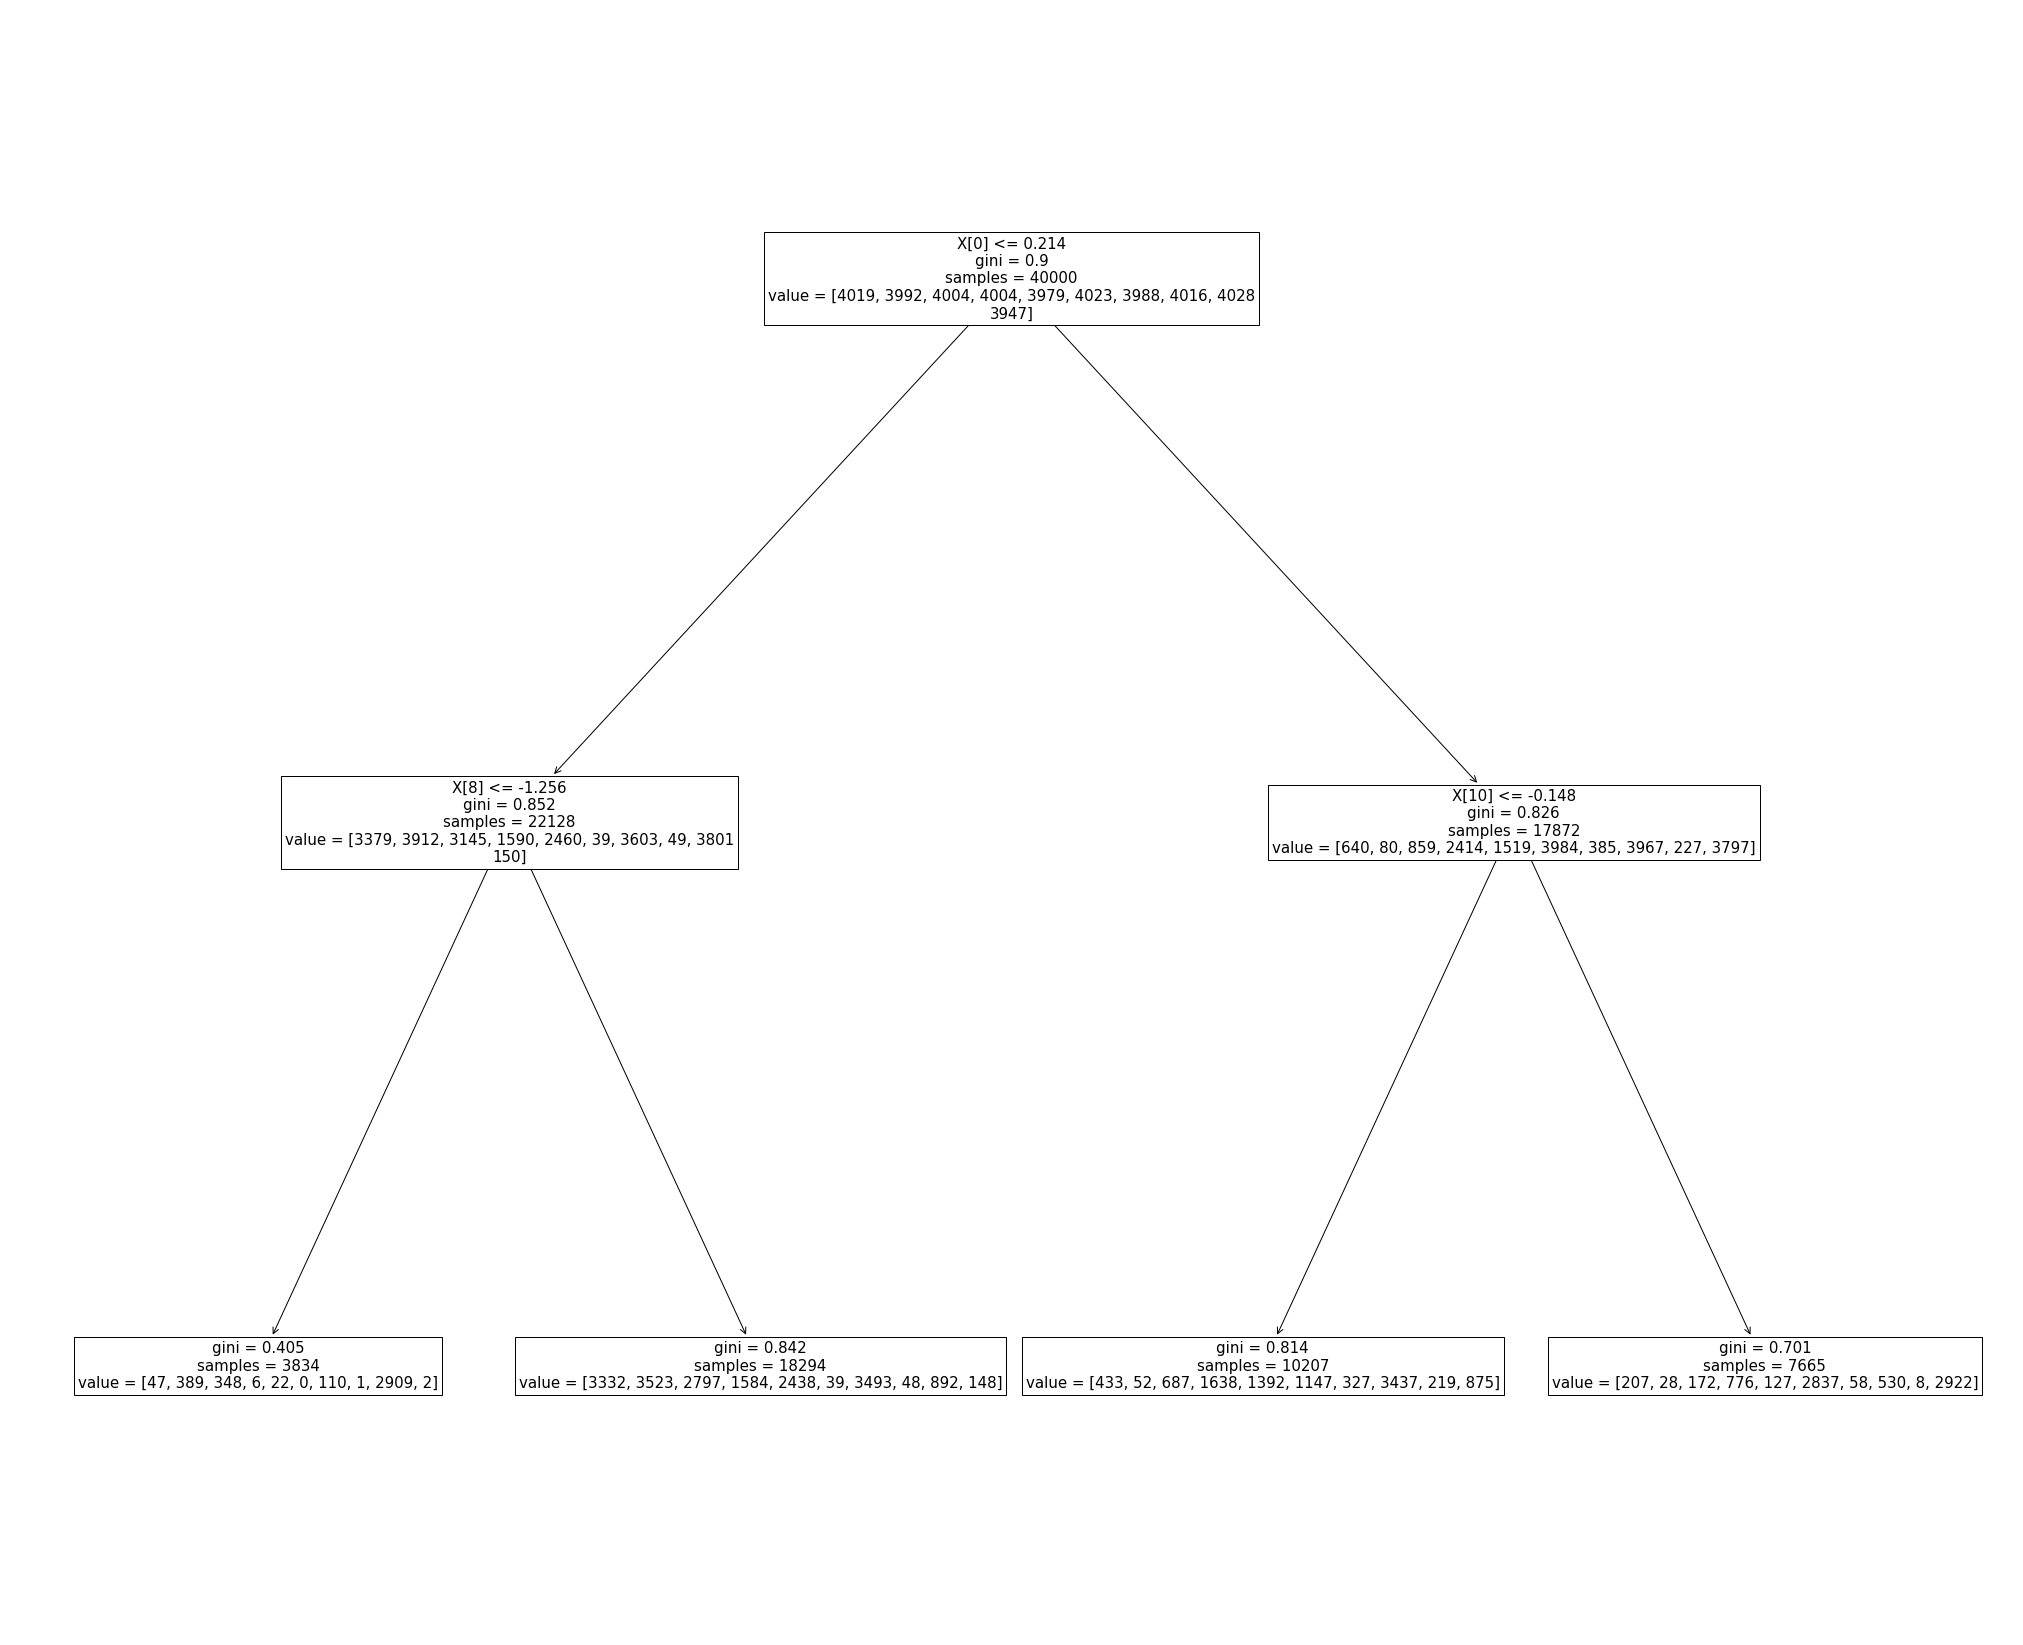

In [14]:
#Building a model
clf = DecisionTreeClassifier(max_depth = 2, random_state = 0)

#Fitting in our data
clf = clf.fit(X_train,y_train)

#Predicting X_test
y_pred = clf.predict(X_test)


#Accuracy of the test
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

fig, axe = plt.subplots(figsize=(36,30))
tree.plot_tree(clf, ax = axe, fontsize=15)

In [15]:
param_grid = {'max_depth': np.arange(3, 6)}

tree = GridSearchCV(DecisionTreeClassifier(), param_grid)

tree.fit(X_train, y_train)
tree_pred = tree.predict_proba(X_test)[:, 1]


print ("DecisionTree: Area under the ROC curve = {}".format(tree))

DecisionTree: Area under the ROC curve = GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([3, 4, 5])})


# ____________________________________________________________________________________________________



## Random Forest 

In [16]:
print(X_train.shape)    # Prints out the shape of the variable.
print(X_test.shape)     # Prints out the shape of the variable.
print(y_train.shape)    # Prints out the shape of the variable.
print(y_test.shape)     # Prints out the shape of the variable.

(40000, 13)
(10000, 13)
(40000,)
(10000,)


In [17]:
tst = RandomForestClassifier(max_depth=2, random_state=0)   # RandomForestRegressor is added.

y_pred1 = tst.fit(X_train, y_train).predict(X_test)         # Fits the model and predicts

print("\n------------------------------------------------------\n")
getScore(y_test, y_pred1)
print("\n------------------------------------------------------\n")
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("\n------------------------------------------------------\n")


------------------------------------------------------

9.5346
              precision    recall  f1-score   support

 Electronic:       0.41      0.63      0.49       981
      Anime:       0.57      0.50      0.53      1008
       Jazz:       0.61      0.03      0.06       996
Alternative:       0.00      0.00      0.00       996
    Country:       0.00      0.00      0.00      1021
        Rap:       0.32      0.31      0.32       977
      Blues:       0.25      0.44      0.32      1012
       Rock:       0.36      0.84      0.50       984
  Classical:       0.62      0.87      0.72       972
    Hip-Hop:       0.47      0.53      0.50      1053

    accuracy                           0.41     10000
   macro avg       0.36      0.42      0.34     10000
weighted avg       0.36      0.41      0.34     10000


------------------------------------------------------

Accuracy: 0.4131

------------------------------------------------------



/projects/afffd160-11c4-4b0e-8185-cf29c729cf98/miniconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/projects/afffd160-11c4-4b0e-8185-cf29c729cf98/miniconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/projects/afffd160-11c4-4b0e-8185-cf29c729cf98/miniconda3/envs/ds_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# ____________________________________________________________________________________________________

## Xgboost:
XgBoost stands for Extreme Gradient Boosting

Overall Accuracy:  0.6491
5.4102


<AxesSubplot:>

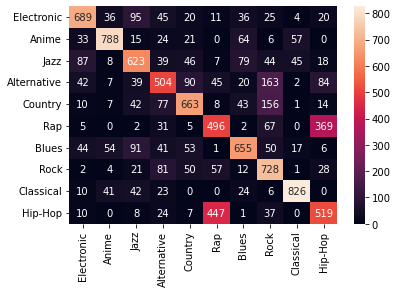

In [18]:

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
y_pred = model.fit(X_train, y_train).predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy: ", accuracy)

total_squared_error = (np.sum((y_test - y_pred)**2))
mean_squared_error = total_squared_error/len(y_test)
print(mean_squared_error)

#confusion matrix
labels = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop']
# sns.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

In [19]:
getScore(y_test, y_pred)

5.4102
              precision    recall  f1-score   support

 Electronic:       0.74      0.70      0.72       981
      Anime:       0.83      0.78      0.81      1008
       Jazz:       0.64      0.63      0.63       996
Alternative:       0.57      0.51      0.53       996
    Country:       0.69      0.65      0.67      1021
        Rap:       0.46      0.51      0.48       977
      Blues:       0.70      0.65      0.67      1012
       Rock:       0.57      0.74      0.64       984
  Classical:       0.87      0.85      0.86       972
    Hip-Hop:       0.49      0.49      0.49      1053

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



# ____________________________________________________________________________________________________